# Imports and Helpers

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from einops import rearrange
import random
from matplotlib.colors import rgb2hex
from tqdm.notebook import tqdm
import os
import copy
import sys
print(sys.version)

# plt.style.use(['dark_background'])
%matplotlib inline
# %matplotlib ipympl

3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]


## Helper funcs

In [2]:
def rearrange_sample(house):
    # this rearranges the training sample into an x y z m shape
    world = rearrange(house, 'z y x b -> x y z b')
    return world

In [3]:
def trim_world_empty(world):
    # this removes empty voxels sorrounding a world
    arr_slices = tuple(np.s_[curr_arr.min():curr_arr.max() + 1] for curr_arr in world[:,:,:,0].nonzero())
    return world[arr_slices]

In [4]:
def pad_world(world):
    # this pads a world to the smallest cubic volume that it can fit in
    (x, y, z, m) = world.shape
    min_dim = max(world.shape[0:3])
    world = np.pad(world, ((0, min_dim - x),(0, min_dim - y),(0, min_dim - z), (0, 0)), 'constant')
    return world
def something():
    return "hi"

## Load some houses

In [5]:
# Explore directory
DATA_DIR = "house_data/houses"
HOUSES_DIRS = [os.path.join(DATA_DIR, o) for o in os.listdir(DATA_DIR) if os.path.isfile(os.path.join(DATA_DIR,o,"schematic.npy"))]
print("Num suable houses in dir:", len(HOUSES_DIRS))

Num suable houses in dir: 2532


In [6]:
# an array for some sample examples
selected_sample_houses_dirs = ["workdir.2018-06-22-16:39:03.ip-172-31-9-250", # match box
    "workdir.2018-06-23-07:16:40.ip-172-31-5-36", # a house with deck
    "workdir.2018-06-22-20:45:54.ip-172-31-2-250", # quartz house
    "workdir.2018-06-23-08:09:44.ip-172-31-10-251", # tree house
    "workdir.2018-06-22-19:13:10.ip-172-31-13-79", # normal hut
    "workdir.2018-06-23-18:11:04.ip-172-31-0-19", # normal hut
]

houses_sample_size = 20
sample_houses_dirs = random.sample(HOUSES_DIRS, houses_sample_size)

sample_houses = [pad_world(trim_world_empty(rearrange_sample(
        np.load(dir + "/schematic.npy")
    ))) for dir in sample_houses_dirs] # a list of houses
selected_sample_houses = [pad_world(trim_world_empty(rearrange_sample(
        np.load(DATA_DIR + "/" + dir + "/schematic.npy")
    ))) for dir in selected_sample_houses_dirs] # a list of houses

print("selected", len(selected_sample_houses_dirs), "houses") # the number of houses loaded
print("sampled", len(sample_houses), "houses") # the number of houses loaded
print("world array has shape", sample_houses[1].shape) # comes in (y, z, x, id/meta) order (y is the height in minecraft)
print("first block in first world arr", sample_houses[1][0, 0 ,0]) # this contains id/meta

selected 6 houses
sampled 20 houses
world array has shape (12, 12, 12, 2)
first block in first world arr [134   2]


# Visualiser

In [7]:
def get_color_dict(unique_vals):
    state = np.random.RandomState(0)
    color_arr = list(state.uniform(0, 1, (len(unique_vals), 3)))
    color_arr = [rgb2hex(color) for color in color_arr]
    color_arr = [None] + color_arr # set all to 0 for air block (block id 0)
    colors = color_arr[: len(unique_vals)] # chop off the last random
    color_dict = {str(unique_vals[i]): colors[i] for i in range(len(unique_vals))} # make string
    return color_dict # return

print("sample colour dict:", get_color_dict(np.array([2,3,4])))

sample colour dict: {'2': None, '3': '#8cb69a', '4': '#8b6ca5'}


In [8]:
def convert_to_color(arr, color_dict):
    new_arr = copy.deepcopy(arr).astype(object)
    for k in color_dict:
        new_arr[new_arr == int(k)] = color_dict[k]
    return new_arr

In [9]:
def visualise_world(worlds, plots_per_row = 4, figsize = (20, 20)):
    
    try:
        _ = worlds[0][0][0][0][0]
    except IndexError:
        worlds = [worlds] 

    fig, axs = plt.subplots(math.ceil(len(worlds)/plots_per_row), plots_per_row, figsize = figsize, subplot_kw={"projection": '3d', "adjustable": 'box'})
    
    try:
        _ = axs[0][0]
    except:
        axs = [axs] 
        
    r, c = 0, 0
    for world in tqdm(worlds):

        (x, y, z, b) = world.shape
        blockidarray, blockmetaarray = world[:,:,:,0], world[:,:,:,1]

        color_dict = get_color_dict(np.unique(blockidarray))
        colors = convert_to_color(blockidarray, color_dict)
        
        meta_color_dict = get_color_dict(np.unique(blockmetaarray))
        edge_colors = convert_to_color(blockmetaarray, meta_color_dict)
        
        axs[r][c].title.set_text('This should be a house')
        axs[r][c].voxels(blockidarray, facecolors=colors, edgecolors=edge_colors)
        c += 1
        if c == plots_per_row:
            c = 0
            r += 1

    plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

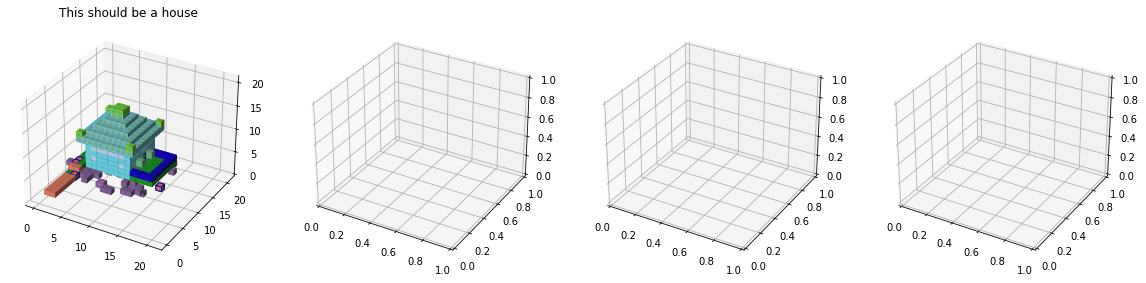

In [10]:
visualise_world(selected_sample_houses[1])

  0%|          | 0/20 [00:00<?, ?it/s]

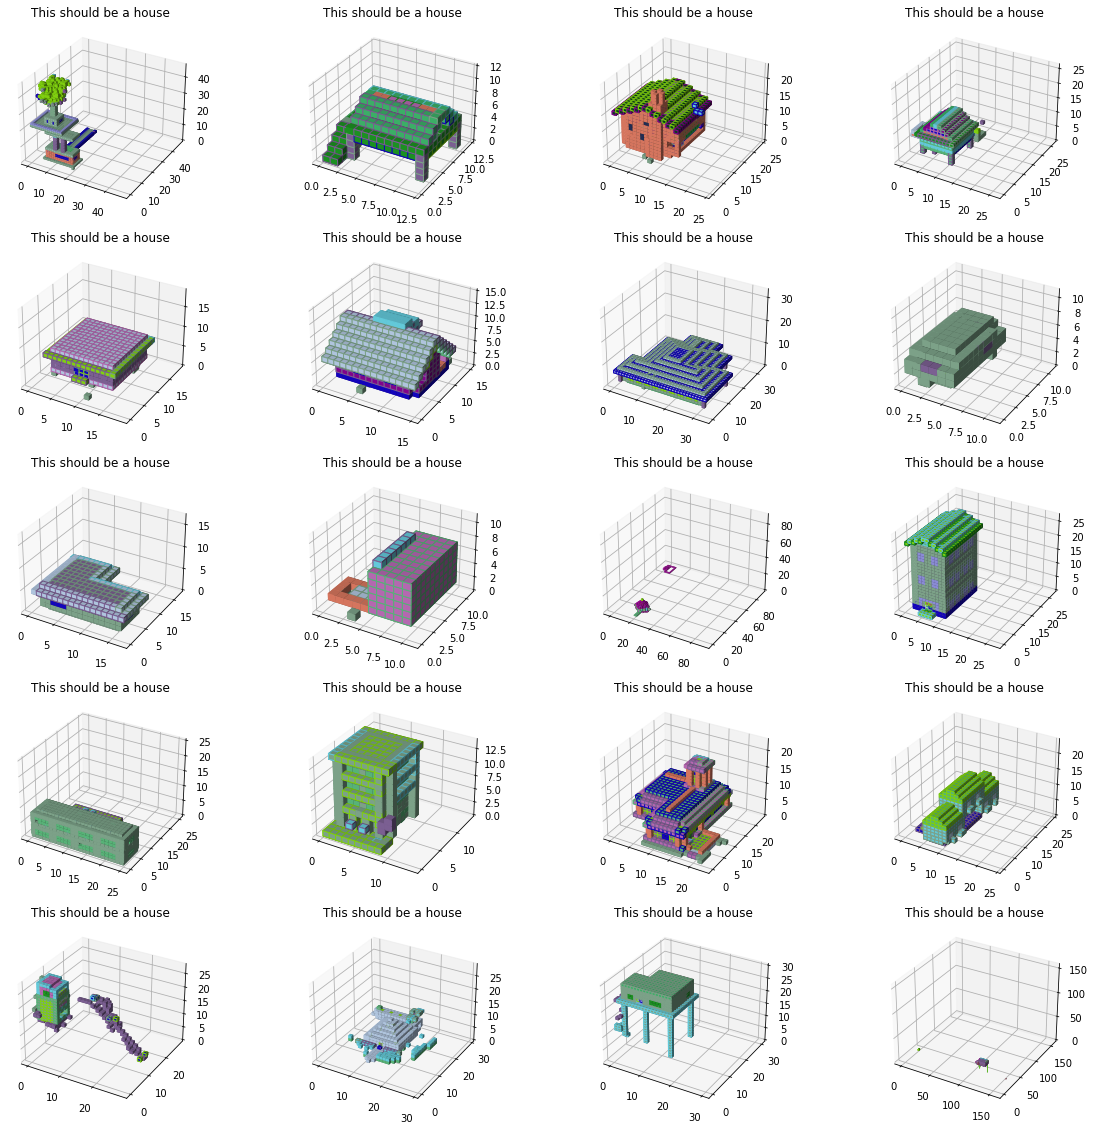

In [11]:
visualise_world(sample_houses)

# Overview stats

- num unique block distribution (exclude meta)
- num unique block distribution (include meta)
- trimmed cube size distribution

While the original paper (cite) provides statistics on, e.g. block types and number of blocks in each house, it's not useful when it comes to selecting usable training examples for the model. 

We run python code to calculate the smallest cuboid box that the training example can fit in.

In [12]:
HOUSES_DIRS[654]

'house_data/houses/workdir.2018-06-24-18:20:27.ip-172-31-1-232'

(9, 140, 108, 2)


  0%|          | 0/1 [00:00<?, ?it/s]

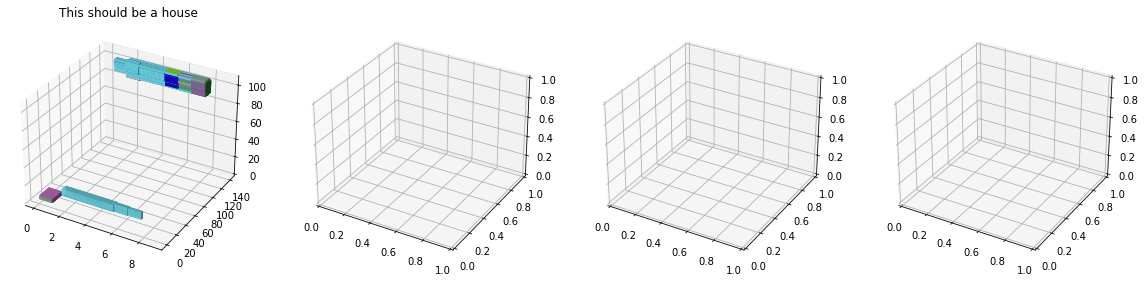

In [20]:
house = HOUSES_DIRS[201]

house = np.load(house + "/schematic.npy")
print(house.shape)

visualise_world(house)

In [14]:
# load all houses

example_houses = []

for dir in tqdm(HOUSES_DIRS):
    try:
        example_houses += [pad_world(trim_world_empty(rearrange_sample(np.load(dir + "/schematic.npy"))))]
    except:
        print(dir)

  0%|          | 0/2532 [00:00<?, ?it/s]

In [44]:
sizes = []
nums_id_types = []
nums_unique_types = []
percentages_air = []

for i, world in enumerate(tqdm(example_houses)):
    # get size
    (x, _, _, _) = world.shape
    blockidarray = world[:,:,:,0]
    blockmetaarray = world[:,:,:,1]
    
    # get size
    sizes += [x]
    if x > 128:
        print("!!! so big of a world!")
        print("at", i, "size", x)

    # get unique block ids
    unique_ids = np.unique(blockidarray)
    nums_id_types += [len(unique_ids)]
    
    # get unique blocks variations
    block_list = rearrange(world, 'x y z m -> (x y z) m')
    nums_unique_types += [len(np.unique(block_list, axis=0))]

  0%|          | 0/2532 [00:00<?, ?it/s]

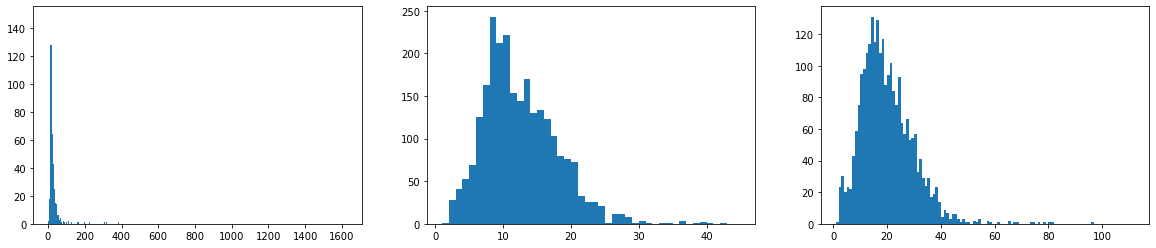

In [43]:
%matplotlib inline
fig, axs = plt.subplots(1, 3, figsize=(20, 4))  # a figure with a 2x2 grid of Axes
axs[0].hist(sizes, bins=range(min(sizes), max(sizes)))
# axs[0].set_yscale('log')
axs[1].hist(nums_id_types, bins=range(min(nums_id_types), max(nums_id_types)))
axs[2].hist(nums_unique_types, bins=range(min(nums_unique_types), max(nums_unique_types)))
plt.show()